In [85]:
import os
import torch
import random
import matplotlib.pyplot as plt

import sys
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)
    
from preprocessing.dataset import SignLanguageDataset

In [86]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())  # Whether to support GPU

2.2.2
False


In [87]:
# Automatically generate category name -> index mapping
frame_root = "../data/frames/train"
class_names = sorted(os.listdir(frame_root))
label_map = {cls: i for i, cls in enumerate(class_names)}
print("Category quantity:", len(label_map))
print("Sample mapping:", list(label_map.items())[:5])

Category quantity: 300
Sample mapping: [('about', 0), ('accident', 1), ('africa', 2), ('again', 3), ('all', 4)]


In [88]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transform = A.Compose([
    # A.LongestMaxSize(224), 
    # A.PadIfNeeded(224, 224, border_mode=0),  
    A.Resize(224, 224),

    A.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.02, hue=0.2, p=0.2),

    A.MotionBlur(blur_limit=1, p=0.2),
    
    A.CoarseDropout(
        max_holes=1, max_height=16, max_width=16,
        min_height=8, min_width=8,
        fill_value=(0, 0, 0), p=0.1 
    ),

    A.RandomBrightnessContrast(
        brightness_limit=0.2,  
        contrast_limit=0.2,  
        p=0.5                  
    ),

    A.Normalize(),
    ToTensorV2()
])

/var/folders/w0/p53f__b5775fykd_h2t7wtqw0000gp/T/ipykernel_82637/117682614.py:13: UserWarning: Argument(s) 'max_holes, max_height, max_width, min_height, min_width, fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(


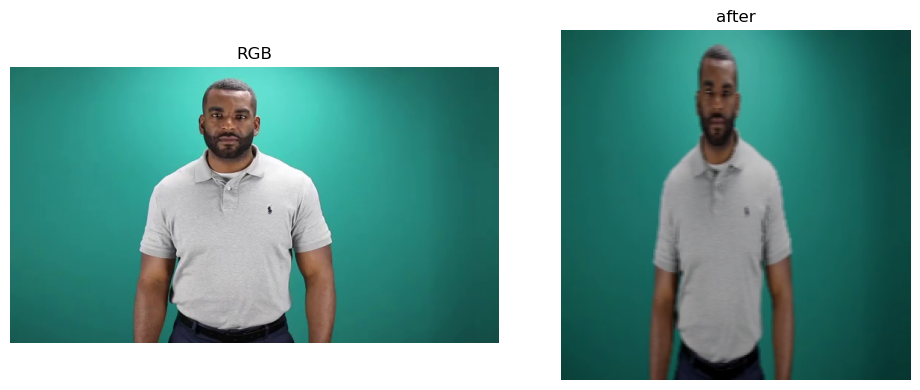

In [89]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

path = "../data/frames/train/write/66815/frame_000.jpg"

# BGR → RGB
image = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)

# 
transformed = train_transform(image=image)["image"]  # shape: [C, H, W], tensor

# De-normalization processing
# ImageNet mean/std
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
img_np = transformed.permute(1, 2, 0).cpu().numpy()  # [C, H, W] → [H, W, C]
img_np = (img_np * std + mean)  # De-normalization
img_np = np.clip(img_np * 255, 0, 255).astype("uint8")

# before and after comparison
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("RGB")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(img_np)
plt.title("after")
plt.axis("off")

plt.tight_layout()
plt.show()


In [90]:
dataset = SignLanguageDataset(
    root_dir=frame_root,
    label_map=label_map,
    transform=train_transform,
    num_frames=20,
    split="train"
)

print("Total number of samples:", len(dataset))


[DEBUG] First 20 samples loaded:
Sample 0: class=write, label=292
    Frame count: 20 | First frame: ../data/frames/train/write/66815/frame_000.jpg
Sample 1: class=write, label=292
    Frame count: 20 | First frame: ../data/frames/train/write/70261/frame_000.jpg
Sample 2: class=write, label=292
    Frame count: 20 | First frame: ../data/frames/train/write/64065/frame_000.jpg
Sample 3: class=write, label=292
    Frame count: 20 | First frame: ../data/frames/train/write/64067/frame_000.jpg
Sample 4: class=write, label=292
    Frame count: 20 | First frame: ../data/frames/train/write/64058/frame_000.jpg
Sample 5: class=write, label=292
    Frame count: 20 | First frame: ../data/frames/train/write/64060/frame_000.jpg
Sample 6: class=write, label=292
    Frame count: 20 | First frame: ../data/frames/train/write/64056/frame_000.jpg
Sample 7: class=write, label=292
    Frame count: 20 | First frame: ../data/frames/train/write/64057/frame_000.jpg
Sample 8: class=write, label=292
    Frame cou

Number of video frames:20, Category index:285


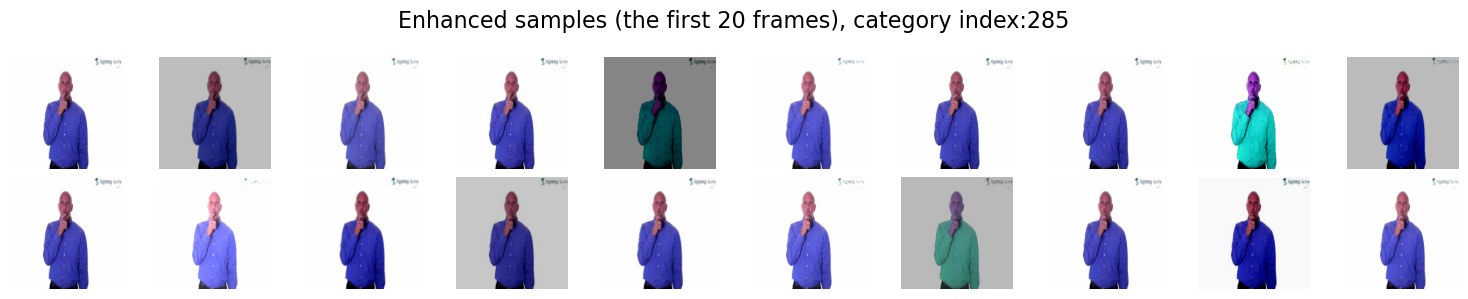

In [91]:
video_tensor, label = random.choice(dataset)

print(f"Number of video frames:{video_tensor.shape[0]}, Category index:{label}")

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

plt.figure(figsize=(15, 3))
for i in range(20):
    img = video_tensor[i].permute(1, 2, 0).cpu().numpy()  # [C, H, W] → [H, W, C]
    img = img * std + mean
    img = np.clip(img * 255, 0, 255).astype("uint8")
    plt.subplot(2, 10, i + 1)
    # plt.imshow((img * 255).astype("uint8"))
    plt.imshow(img)
    plt.axis("off")
    
plt.suptitle(f"Enhanced samples (the first 20 frames), category index:{label}", fontsize=16)
plt.tight_layout()
plt.show()